## Notebook contains:

* Compare bellman ford to BF moore
* attempts for distance cost from the actual path
* Add emergency points only where necessary (dilation)
* Agglomerative clustering
* Build graph from clustered pos2node
* Watershed transform

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import networkx as nx
import time
from graph_tool.all import *
import pickle

/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [52]:
from power_planner.utils import get_half_donut

In [ ]:
path = "/Users/ninawiedemann/Downloads/tifs_new/tif_layers/Buildingftp.tif"
with rasterio.open(path, 'r') as ds:
    arr = ds.read()[0]

In [ ]:
np.unique(arr)

In [83]:
IOPATH = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_5.dat"
with open(IOPATH, "rb") as infile:
    (instance, instance_corr, start_inds, dest_inds) = pickle.load(infile)

In [ ]:
plt.hist(instance.flatten())
plt.show()

In [ ]:
emerg = np.zeros((20,20))
max_dist = 1.5
for row in np.arange(1,20,max_dist).astype(int):
    emerg[row, np.arange(1,20,max_dist).astype(int)] = 1

### slow version dist arr

In [ ]:
start_inds = np.asarray([163, 24])
dest_inds = np.asarray([94, 240])

In [ ]:
dist_arr = np.zeros(instance.shape)
norm = np.linalg.norm(dest_inds-start_inds)
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        p3 = np.asarray([i,j])
        dist_arr[i,j] = np.abs(np.cross(dest_inds-start_inds, start_inds-p3)) / norm

In [ ]:
plt.imshow(dist_arr)
plt.show()

### fast version for dist arr, but rotation padding problem

In [ ]:
from scipy.ndimage import rotate

In [ ]:
size = np.linalg.norm(dest_inds-start_inds)
size = int(size)
arr = np.zeros((size,size))
arr[:,:size//2] = np.stack([np.arange(size//2) for _ in range(size)])
arr[:,size//2:] = np.vstack([np.arange(size//2,0,-1).tolist() for _ in range(size)])
ang = 90 + 90 * angle([0,1], dest_inds-start_inds)/np.pi
w,h = instance.shape
dist_arr = np.pad(rotate(arr, ang), ((0, w-size), (0,h-size)))

## construct constraint

In [ ]:
start_inds = [163, 24]
dest_inds = [94, 240]
start_dest_inds = np.array([start_inds, dest_inds])
inter_line = start_dest_inds[0]-start_dest_inds[1]
longer = np.argmin(np.abs(inter_line))

padding = [0,0]
percent_padding = 0.25
padding[longer] = abs(int(percent_padding*inter_line[longer]))

start_x, start_y = np.min(start_dest_inds, axis=0) - np.asarray(padding)
end_x, end_y = np.max(start_dest_inds, axis=0) + np.asarray(padding)

corr = np.zeros(instance.shape)
corr[start_x:end_x, start_y:end_y] = 1

In [ ]:
hard_cons = corr * instance_corr # hard_constraints

In [ ]:
max_dist = 10
w_inds = np.arange(start_x, end_x, max_dist).astype(int)
h_inds = np.arange(start_y, end_y, max_dist).astype(int)

# max_cost = np.max(costs)
for row in w_inds:
    hard_cons[row, h_inds] = 1
    # costs[row, h_inds] = max_cost


In [ ]:
padding

In [ ]:
start_x, start_y

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(hard_cons) # possible)
plt.show()

## Test algorithms on instance

In [ ]:
INP = "/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/path_70055.weighted.edgelist"

In [ ]:
g = nx.read_edgelist(
                INP,
                nodetype=float,
                create_using=nx.DiGraph,
                data=(('weight', float), )
            )

In [ ]:
vec = np.linalg.norm([-173, 539])

In [ ]:
cutoff = 4*vec/15
cutoff

In [ ]:
class SP():
    def __init__(self, graph):
        self.graph = graph

    def bellman_ford_my(self, source, target, cutoff):
        """
        Actual BF algorithm, not SPFA
        """
        pred = {}
        dist = {source: 0}

        inf = float('inf')

        for i in range(int(cutoff)):
            print(i)
            for (u, v, w_dict) in self.graph.edges(data=True):
                w = w_dict["weight"]
                if dist.get(u, inf) + w < dist.get(v, inf):
                    dist[v] = dist[u] + w
                    pred[v] = u
        path = [target]
        curr = target
        while curr != source:
            curr = pred[curr]
            path.append(curr)
        path.append(source)
        return list(reversed(path))

    def bellman_ford_nx(
        self,
        source,
        target,
        pred=None,
        paths=None,
        dist=None,
    ):
        """Relaxation loop for Bellman–Ford algorithm.
        This is an implementation of the SPFA variant.
        See https://en.wikipedia.org/wiki/Shortest_Path_Faster_Algorithm
        Parameters
        SEE https://github.com/networkx/networkx/blob/02a1721276b3a84d3be8558e4
        79a9cb6b0715488/networkx/algorithms/shortest_paths/weighted.py#L1203
        """
        G = self.graph
        weight = lambda u, v, data: data.get("weight", 1)
 
        # vertices_path = self.bellman_ford(source, target, cutoff)
        paths = {source: [source]}
        # dist, it_list = self._bellman_ford(self.graph, [source], weight, cutoff, paths = paths, target=target)
        # vertices_path = paths[target]
        source = [source]
        
        for s in source:
            if s not in G:
                raise nx.NodeNotFound(f"Source {s} not in G")

        if pred is None:
            pred = {v: [] for v in source}

        if dist is None:
            dist = {v: 0 for v in source}

        G_succ = G.succ if G.is_directed() else G.adj
        print("directed?", G.is_directed())
        inf = float('inf')
        n = len(G)

        # count = {}
        q = deque(source)
        in_q = set(source)
        iteration = 0
        it_list = []
        while q:
            u = q.popleft()
            in_q.remove(u)
            
            it_ind = 0
            
            # print("new vertex", u)

            # Skip relaxations if any of the predecessors of u is in the queue.
            if all(pred_u not in in_q for pred_u in pred[u]):
                dist_u = dist[u]
                # print(dist_u)
                for v, e in G_succ[u].items():
                    dist_v = dist_u + weight(u, v, e)  # TODO:replace function
                    # print(v)
                    if dist_v < dist.get(v, inf):
                        
                        if v not in in_q:
                            # print("update")
                            q.append(v)
                            in_q.add(v)
                            # count_v = count.get(v, 0) + 1
                            # if count_v == n:
                            #     raise nx.NetworkXUnbounded(
                            #         "Negative cost cycle detected."
                            #     )
                            # count[v] = count_v
                        dist[v] = dist_v
                        pred[v] = [u]

                    elif dist.get(v) is not None and dist_v == dist.get(v):
                        pred[v].append(u)
                    
                    it_ind += 1
            else:
                # pass
                print("err")
            
            it_list.append(it_ind)
            iteration += 1

            # TODO
            # if u == target:
            #     print("early stopping")
            #     break
            # if iteration > cutoff and dist.get(target, inf) < inf:
                # print("iteration more than cutoff")
                # if dist.get(target, inf) < inf:
                # print("early stopping")
                # break
        print("number of iterations:", iteration)
        if paths is not None:
            dsts = [target] if target is not None else pred
            for dst in dsts:

                path = [dst]
                cur = dst

                while pred[cur]:
                    cur = pred[cur][0]
                    path.append(cur)

                path.reverse()
                paths[dst] = path

        return paths[target], it_list # dist, it_list
from collections import deque


In [ ]:
g_undir = g.to_undirected()

In [ ]:
print("Start shortest path")
sp = SP(g)
out = sp.bellman_ford_nx(43104, 8447) # , it_list

## Test results:

* graph with 5.6 mio edges, 50 000 nodes
* directed case: 50757 terations, so slightly more than the nodes --> doch cycles --> maybe because of 180 degrees thing? (15 sec)
* undirected case: 59042 iterations why not more? though more iterations in each iteration probably, takes longer (26 sec)


* my algorithm: 10 minutes! (for 150 iterations) --> basically 150 times the runtime of the other ones
* with directed edges, other algorithm: 5 837 055, but just twice the time 12 753 072 if undirected


* because of Skip relaxations if any of the predecessors of u is in the queue?

sanity check was correct: inner iteration (over neighbors) is twice as much for undirected as for directed

In [ ]:
len(g.edges)

In [ ]:
len(g.nodes)

### total iterations for directed / undirected:

In [ ]:
print(50757*115, 59042*216)

### Sanity check

In [ ]:
np.mean(it_list)

In [ ]:
plt.hist(it_list)
plt.show()

In [ ]:
np.mean(it_list)

In [ ]:
plt.hist(it_list)
plt.show()

## Random graph tests

In [ ]:
comp = nx.complete_graph(100)

In [ ]:
len(comp.edges())

In [ ]:
sp = SP(comp)
out, its = sp.bellman_ford_nx(0, 5) # , it_list

In [ ]:
sum(its)

In [ ]:
g_new = nx.DiGraph()
e = []
# for i in range(20):
#    e.append([i,i+1,{"weight":i}])
for i in range(1,4):
    e.append([0,i,{"weight":i}])
for i in range(1,4):
    e.append([i,5, {"weight":i}])
g_new.add_edges_from(e)

In [ ]:
sp = SP(g_new)
out = sp.get_shortest_path_nx(0, 5) # , it_list

In [ ]:
nx.write_weighted_edgelist(
                g_new,'test.weighted.edgelist'
            )

In [ ]:
in_g_new = nx.read_edgelist(
                'test.weighted.edgelist',
                nodetype=int,
    create_using=nx.DiGraph,
                data=(('weight', float), )
            )

In [ ]:
in_g_new_dir = nx.DiGraph(in_g_new)

In [ ]:
in_g_new.out_edges()

In [ ]:
g_new.edges()

In [ ]:
len(comp.nodes()), len(comp.edges())

In [ ]:
g1 = Graph()
g1.add_vertex(20)
g1.add_edge_list([[i,i+1] for i in range(19)])

In [ ]:
len(list(g1.vertices())), len(list(g1.edges()))

In [ ]:
len(list(comp.nodes())), len(list(comp.edges()))

## subplots for paths

In [ ]:
a = np.zeros((500,1000))
a[200:260, 100:500] = np.arange(24000).reshape(60,400)
a = np.swapaxes(a,1,0)

In [ ]:
b = a[:, np.any(a>0, axis=0)]
b = b[np.any(b>0, axis=1), :]

In [ ]:
b = np.arange(20).reshape(2,10)
b.shape

In [ ]:
x

In [ ]:
plt.figure(figsize=(25,15))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(b)
    plt.axis('scaled')
plt.tight_layout()
plt.show()

## Summarize points

In [275]:
inst = instance_corr * instance
test = inst[:, np.any(inst > 0, axis=0)]
test = test[np.any(test > 0, axis=1), :]

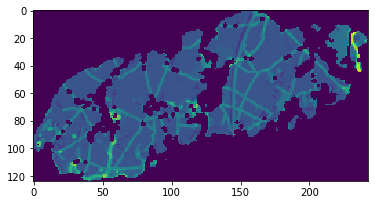

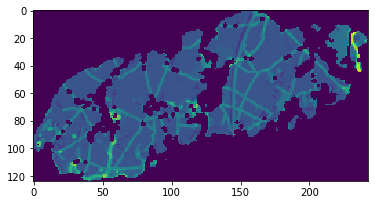

In [276]:
plt.imshow(test)
plt.show()

In [ ]:
# can put same node in several places of pos2node
# summarize pixels: with similar value?
# from image compression
# put gaussian smoothing on top? --> then take similar ones together?
# problem clustering: what about different resistance classes
# distance constraint? take highest or lowest distance to cluster
# different resistance classes = colour channels
# graph representation: make edges strong between similar values, then find cuts
# take position and costs together and do kmeans clustering

In [6]:
from PIL import Image

In [232]:
def reduce(img, scale_factor):
    x_len_new = img.shape[0] // scale_factor
    y_len_new = img.shape[1] // scale_factor
    new_img = np.zeros((x_len_new, y_len_new))
    for i in range(x_len_new):
        for j in range(y_len_new):
            patch = img[i * scale_factor:(i + 1) *
                        scale_factor, j *
                        scale_factor:(j + 1) * scale_factor]
            new_img[i, j] = np.mean(patch)
    return np.swapaxes(new_img, 1, 0)

inst = reduce(test, 20)
# inst = (inst>0.4).astype(int)

In [5]:
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

In [242]:
smoothened_coins = inst # gaussian_filter(inst, sigma=1)

X = np.reshape(smoothened_coins, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*smoothened_coins.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 20  # number of regions
ward = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity ="l1", distance_threshold=0.2,
                               connectivity=connectivity) # n_clusters=n_clusters,
ward.fit(X)
label = np.reshape(ward.labels_, smoothened_coins.shape)

Compute structured hierarchical clustering...
Compute structured hierarchical clustering...


In [38]:
connectivity

<780x780 sparse matrix of type '<class 'numpy.int64'>'
	with 3788 stored elements in COOrdinate format>

<780x780 sparse matrix of type '<class 'numpy.int64'>'
	with 3788 stored elements in COOrdinate format>

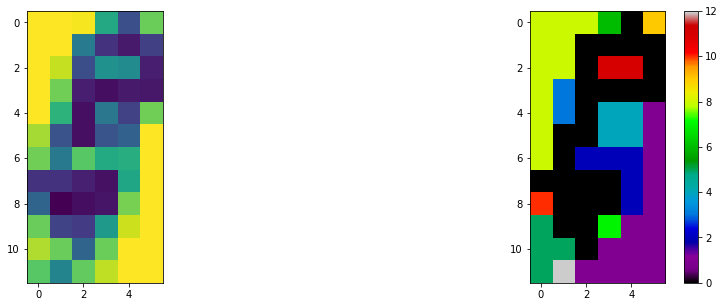

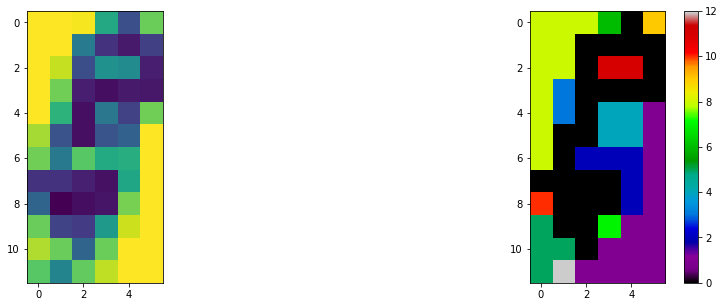

In [243]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(inst)
plt.subplot(1,2,2)
plt.imshow(label, interpolation='nearest', cmap=plt.cm.nipy_spectral) # , cmap=plt.cm.gray)
# for l in range(n_clusters):
#     plt.contour(label == l,
#                 colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.colorbar()
plt.show()



In [294]:
def clustering(inst, n_clusters, plot=True):

    X = np.reshape(inst, (-1, 1))

    # Define the structure A of the data. Pixels connected to their neighbors.
    connectivity = grid_to_graph(*inst.shape)

    # print("Compute structured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', affinity ="euclidean", # l1",
                                   connectivity=connectivity)
    ward.fit(X)
    label = np.reshape(ward.labels_, inst.shape)
    # print("time passed", time.time()-st)
    
    if plot:
        plt.figure(figsize=(15, 5))
        plt.subplot(1,2,1)
        plt.imshow(inst)
        plt.subplot(1,2,2)
        plt.imshow(label, interpolation='nearest', cmap=plt.cm.nipy_spectral)
        plt.colorbar()
        plt.show()
    return label

In [105]:
x,y = instance_corr.shape

In [ ]:
# unterteile bild in several parts, compute clusters for each of them

In [ ]:
pos2node  = label # just saying for each one where we have the corresponding
new cost instance = # mean of patch?

In [ ]:
for i in range(x):
    for j in range(y):
        if instance_corr[i,j] == instance_corr[i,j]

In [277]:
import math
import numpy

def split_to_shape(a, chunk_shape, start_axis=0):
    if len(chunk_shape) != len(a.shape):
        raise ValueError('chunk length does not match array number of axes')

    if start_axis == len(a.shape):
        return a

    num_sections = math.ceil(a.shape[start_axis] / chunk_shape[start_axis])
    # print(num_sections)
    split = numpy.array_split(a, num_sections, axis=start_axis)
    return [split_to_shape(split_a, chunk_shape, start_axis + 1) for split_a in split]

full_split = split_to_shape(test, (3,3))
print({i2.shape for i in full_split for i2 in i})

{(2, 3), (3, 3)}
{(2, 3), (3, 3)}


In [295]:
n_vals = len(np.unique(test))
compress = 2

out = np.zeros(test.shape)
labs_start = 0
x_done = 0
for row_splits in full_split:
    y_done = 0
    for col_splits in row_splits:
        if np.any(col_splits):
            x,y = col_splits.shape
            # distinct_vals = len(np.unique(col_splits))
            # out_labs = int(np.ceil(distinct_vals/compress))
            # print("out labs", out_labs)
            out_labs = 2
            labs = clustering(col_splits, out_labs, plot=False)
            out[x_done:x_done+x, y_done:y_done+y] = labs + labs_start
            y_done += y
            labs_start += np.max(labs)+1
    x_done+= x
    # labs = clustering(p)

In [ ]:
# plt.imshow(test)
# plt.colorbar()
# plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out[99:102, 63:66])
plt.colorbar()
plt.show()

In [34]:
from power_planner.utils import *

In [53]:
shifts = get_half_donut(3,5,[1,1])
# pos2node = out

In [69]:
shifts[0]

(-3, 3)

(-3, 3)

In [37]:
hard_constraints = np.zeros(out.shape)
hard_constraints[5:-5, 5:-5] = 1

In [65]:
prev_vertices = out[hard_constraints>0]

In [40]:
prev_vertices[:10]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [56]:
costs_shifted = shift_surface(test, shifts[0])

In [49]:
weights = (costs_shifted + test)/2

In [66]:
nodes_shifted = shift_surface(pos2node.copy(), shifts[0])[hard_constraints>0]

In [67]:
print(len(prev_vertices), len(nodes_shifted))

26562 26562
26562 26562


In [79]:
weights_list = weights[hard_constraints>0]

In [80]:
inds_arr = np.asarray([prev_vertices, nodes_shifted, weights_list])
inds_arr.shape
# inds_weights = np.concatenate((inds_arr, weights_arr), axis=0)

(3, 26562)

(3, 26562)

In [82]:
import pandas as pd

In [107]:
# remove duplicates
df = pd.DataFrame(np.swapaxes(inds_arr, 1, 0), columns=["1", "2", "3"])

In [108]:
# df.drop_duplicates()
df = df[df["3"]>0] # cost greater zero --> cannot be both forbidden nodes

In [109]:
df = df[df["1"]!=df["2"]] # not from one node to itself

In [96]:
a, b = np.where(out==195)

In [111]:
df = df.groupby(["1","2"], as_index=False).agg({"3":"mean"})

In [128]:
grouped = np.array(df)

In [189]:
125*243

30375

30375

# Build graph

In [57]:
from power_planner.utils import get_half_donut, shift_surface
import pandas as pd

In [142]:
pos2node = out.copy()
# instance = test.copy()
hard_constraints = (test>0).astype(int)
# instance[instance==0] = 1
shifts = get_half_donut(3,5,[1,1])
max_cost = np.max(instance)
print(max_cost)
d = 2
tic = time.time()
emerg_counter = np.max(pos2node)
print(emerg_counter)
for i in range(d, len(hard_constraints)-d):
    for j in range(d, len(hard_constraints[0])-d):
        if not np.any(hard_constraints[i - d:i + d, j - d:j + d]):
            hard_constraints[i, j] = 1
            test[i, j] = max_cost
            pos2node[i,j] = emerg_counter
            emerg_counter+=1

0.9535483870967741
3321


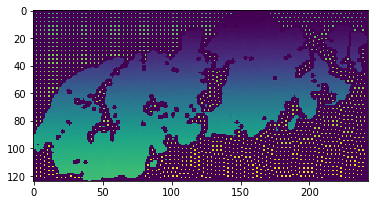

In [143]:
plt.imshow(pos2node)
plt.show()

In [144]:
g = Graph(directed=True)

In [145]:
start_vertex_ind = pos2node[100,25]
dest_vertex_ind = pos2node[20,240]

In [148]:
n_nodes

4807

In [147]:
n_nodes = len(np.unique(pos2node))
_ = g.add_vertex(n_nodes)

In [149]:
weight = g.new_edge_property("float")

In [180]:
inds = pos2node>0
x_inds, y_inds = np.where(inds)
print(np.mean(x_inds), np.mean(y_inds))

np.mean(np.vstack([x_inds, y_inds]), axis = 1)

61.16514320536258 114.40083959645203


array([ 61.16514321, 114.4008396 ])

In [170]:
prev_vertices = pos2node[hard_constraints>0]
for shift in shifts[:1]:
    costs_shifted = shift_surface(test, shift)
    weights = (costs_shifted + test)/2
    nodes_shifted = shift_surface(pos2node.copy(), shift)[hard_constraints>0]
    weights_list = weights[hard_constraints>0]
    inds_arr = np.asarray([prev_vertices, nodes_shifted, weights_list])
    # print(inds_arr.shape)
    df = pd.DataFrame(np.swapaxes(inds_arr, 1, 0), columns=["1", "2", "3"])
    print(shift)
    print(df.head(20))
    df = df[df["3"]>0]
    df = df[df["2"]>0]
    df = df[df["1"]>0]
    df = df[df["1"]!=df["2"]]
    df = df.groupby(["1","2"], as_index=False).agg({"3":"sum"})
    # problem: only summing up the ones going to the same pair --> 163 to 195 can have low weights, but there can be 1000 points in cluster 163
    edges = np.array(df)
    g.add_edge_list(edges, eprops=[weight])

(-3, 3)
         1       2         3
0      1.0    16.0  0.229032
1      4.0    14.0  0.216129
2      4.0    14.0  0.217097
3      1.0    15.0  0.227419
4      1.0    16.0  0.227419
5      1.0    16.0  0.225806
6      6.0    17.0  0.225806
7      6.0    17.0  0.224194
8      7.0    17.0  0.209032
9      7.0    18.0  0.262903
10     8.0    18.0  0.267742
11     8.0    19.0  0.301290
12     9.0    20.0  0.359677
13  3321.0     0.0  0.476774
14  3322.0  3392.0  0.953548
15  3323.0  3393.0  0.953548
16  3324.0  3394.0  0.953548
17  3325.0  3395.0  0.953548
18  3326.0  3396.0  0.953548
19  3327.0  3397.0  0.953548


In [151]:
vertices_path, _ = shortest_path(
                g,
                g.vertex(start_vertex_ind),
                g.vertex(dest_vertex_ind),
                weights=weight,
                negative_weights=True
            )

In [160]:
path_map = np.zeros(out.shape)
col = 1
for v in vertices_path:
    v_ind = g.vertex_index[v]
    inds = np.where(pos2node==v_ind)
    min_val = 1
    for (i,j) in zip(inds[0], inds[1]):
        # print(test[i,j])
        if test[i,j] < min_val:
            min_val = test[i,j]
            min_ind_x = i
            min_ind_y = j
    # print(v_ind)
    path_map[min_ind_x, min_ind_y]= col
    col += 1

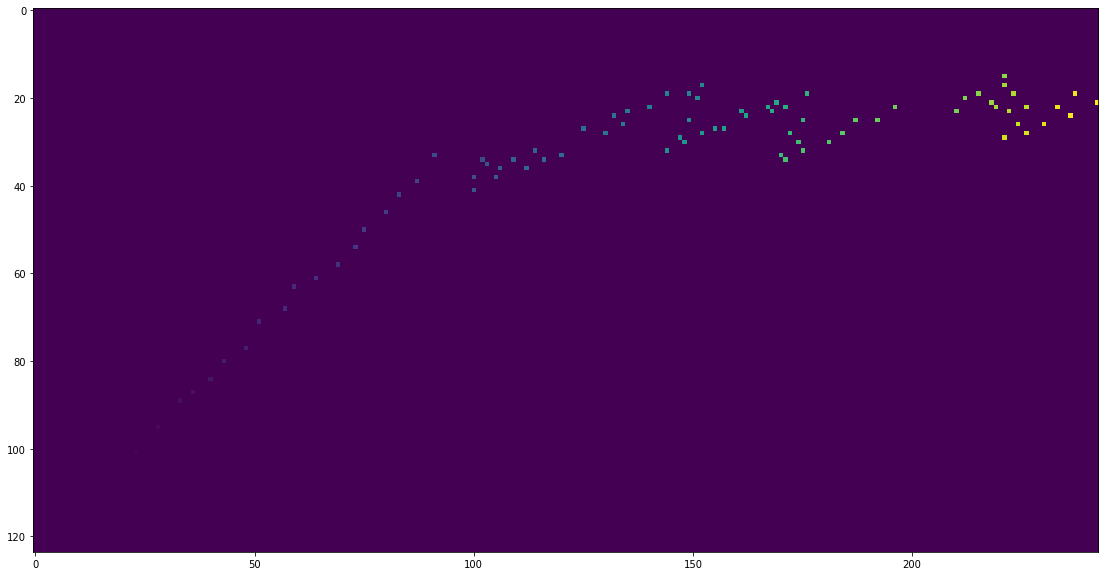

In [161]:
plt.figure(figsize=(20,10))
plt.imshow(path_map)
plt.show()

In [108]:
test[:10,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.95354839, 0.        , 0.        ,
        0.95354839, 0.        , 0.        , 0.95354839, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.95354839, 0.        , 0.        ,
        0.95354839, 0.        , 0.        , 0.95354839, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

### Testing

In [110]:
df.head()

,1,2,3
134,143.0,195.0,0.127097
135,143.0,195.0,0.123226
142,379.0,195.0,0.217419
143,379.0,195.0,0.218387
144,379.0,195.0,0.219355


,1,2,3
134,143.0,195.0,0.127097
135,143.0,195.0,0.123226
142,379.0,195.0,0.217419
143,379.0,195.0,0.218387
144,379.0,195.0,0.219355


In [113]:
df[df["1"]==143]

,1,2,3
241,143.0,5.0,0.156613
242,143.0,6.0,0.112258
243,143.0,43.0,0.167419
244,143.0,47.0,0.197419
245,143.0,48.0,0.124839
246,143.0,57.0,0.129032
247,143.0,71.0,0.102903
248,143.0,74.0,0.130645
249,143.0,75.0,0.161290
250,143.0,77.0,0.183548


,1,2,3
241,143.0,5.0,0.156613
242,143.0,6.0,0.112258
243,143.0,43.0,0.167419
244,143.0,47.0,0.197419
245,143.0,48.0,0.124839
246,143.0,57.0,0.129032
247,143.0,71.0,0.102903
248,143.0,74.0,0.130645
249,143.0,75.0,0.161290
250,143.0,77.0,0.183548


In [124]:
t = np.where(out==143)

In [125]:
new_inds = (t[0]-3, t[1]+3)

In [126]:
for (i,j) in zip(new_inds[0], new_inds[1]):
    o = out[i,j]
    if o==195:
        print(weights[i,j])

0.11935483870967742
0.12709677419354837
0.11935483870967742
0.12709677419354837


## fill random points for empty areas

In [264]:
example = (test<1).astype(int).copy()

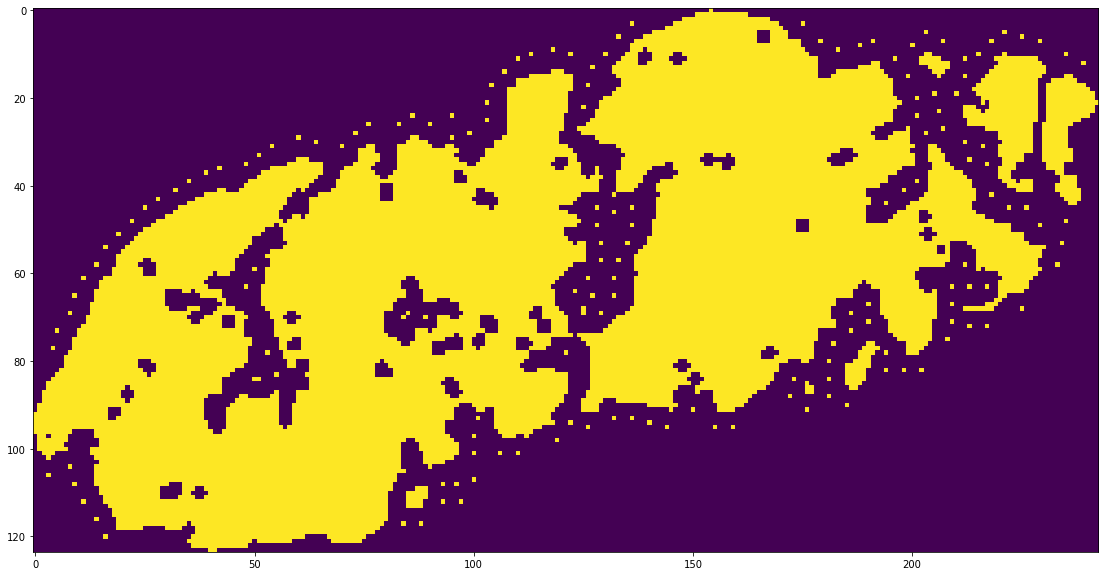

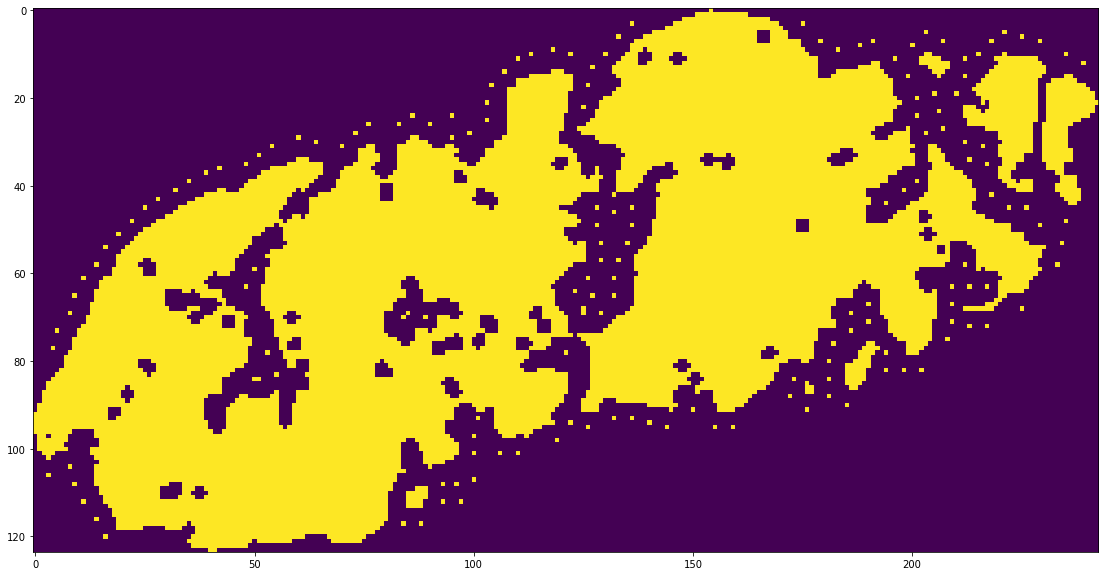

In [271]:
# quick fix: only better emergency points for parcels:
plt.figure(figsize=(20,10))
plt.imshow(example)
plt.show()

In [270]:
# im verhältnis zu number of pixels in this part
dist = 3
x,y = example.shape
for i in range(dist,x-dist):
    for j in range(dist,y-dist):
        if ex2[i,j]:
            if not np.any(example[i-dist:i+dist, j-dist:j+dist]):
                example[i,j] = 1

In [261]:
from scipy.ndimage.morphology import binary_dilation

In [269]:
ex2 = binary_dilation(example, iterations=5)

## watershed segmentation

In [3]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data, util, filters, color

In [87]:
def watershed_transform(img, n_clusters, compact=0.01):
    greater_zero = (img>0).astype(int)
    edges = filters.sobel(img)
    
    ratio_zero = np.sum(greater_zero)/len(greater_zero.flatten())
    n_seeds = n_clusters/ratio_zero
    
    grid = util.regular_grid(img.shape, n_points=n_seeds)
    seeds = np.zeros(img.shape, dtype=int)
    seeds[grid] = np.arange(seeds[grid].size).reshape(seeds[grid].shape) + 1
    seeds = seeds*greater_zero
    print("number seeds then", np.sum(seeds>0))
    
    w1 = watershed(edges, seeds, compactness=compact)
    
    w1_g_zero = (w1+1)*greater_zero
    labels = np.unique(w1_g_zero)
    transformed = np.zeros(w1.shape).astype(int)
    nr_members = np.zeros(w1.shape).astype(int)
    for i,lab in enumerate(labels):
        inds = w1_g_zero==lab
        transformed[inds] = i
        nr_members[inds] = np.sum(inds)
    
    return transformed, nr_members

In [15]:
def transform_cols(arr):
    uni = np.unique(arr)
    transformed = np.zeros(int(np.max(uni)+1))
    for i, u in enumerate(uni):
        transformed[int(u)] = i
    cols = np.random.rand(len(uni),3)
    x,y = arr.shape
    new = np.zeros((x,y,3))
    for i in range(x):
        for j in range(y):
            new[i,j] = cols[int(transformed[int(arr[i,j])])]
    return new   


In [193]:
inst = instance_corr * instance
test = inst[:, np.any(inst > 0, axis=0)]
test = test[np.any(test > 0, axis=1), :]

In [138]:
# take weighted sum of different cost surfaces --> this is what needs to be similar in the end?
out, members = watershed_transform(test,5000)
cols = transform_cols(out)

number seeds then 3321


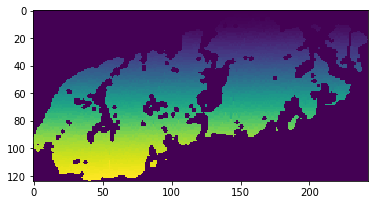

In [182]:
plt.imshow(out)
plt.show()

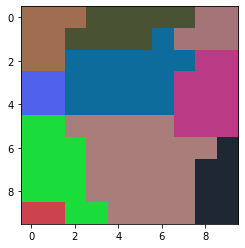

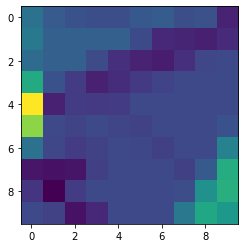

In [18]:
plt.imshow(cols[90:100, 60:70])
plt.show()
# print(w0[90:100, 60:70])
plt.imshow(test[90:100, 60:70])
plt.show()

In [33]:
np.max(out), len(np.unique(out))

(834, 834)

# Compare standard deviation

In [140]:
uni, cou = np.unique(members, return_counts=True)

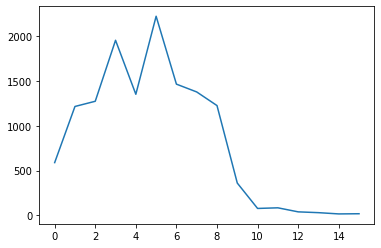

In [141]:
plt.plot(cou[:-1])

In [195]:
print("no nodes now", len(np.unique(out)), "previously <0", np.sum(test>0))

no nodes now 3322 previously <0 13283


In [204]:
def reduce(img, scale_factor):
    x_len_new = img.shape[0] // scale_factor
    y_len_new = img.shape[1] // scale_factor
    new_img = np.zeros((x_len_new, y_len_new))
    std_img = np.zeros((x_len_new, y_len_new))
    for i in range(x_len_new):
        for j in range(y_len_new):
            patch = img[i * scale_factor:(i + 1) *
                        scale_factor, j *
                        scale_factor:(j + 1) * scale_factor]
            new_img[i, j] = np.mean(patch)
            std_img[i,j] = np.std(patch)
    return np.swapaxes(new_img, 1, 0), np.swapaxes(std_img, 1, 0)


In [205]:
red, stds = reduce(test, 2)

In [201]:
print("actual reduce function number >0:", np.sum(red>0))

actual reduce function number >0: 3639


In [212]:
members[members>1000] = 0
print(np.mean(members[members>0]))

5.568546262139577


In [218]:
np.sum(members)/5.5685

13283.110352877795

In [219]:
stds_out = []
for i, val in enumerate(np.unique(out)):
    if val==0:
        continue
    vals = test[out==val]
    stds_out.append(np.std(vals))

In [220]:
print(len(stds_out))

3321


In [223]:
actual_stds = stds[red>0]

In [224]:
np.mean(actual_stds)

0.042604095609047855

In [225]:
np.mean(stds_out)

0.015534246886967095

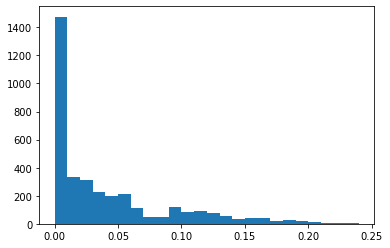

In [231]:
plt.hist(actual_stds, bins = np.arange(0,0.25,0.01))
plt.show()

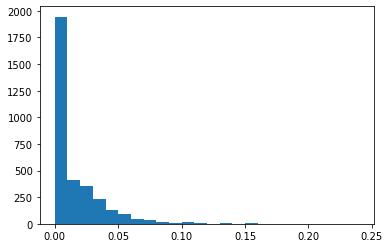

In [230]:
plt.hist(stds_out, bins = np.arange(0,0.25,0.01))
plt.show()

# Time of watershed

In [245]:
from power_planner.utils import normalize

In [246]:
path_layers = "/Users/ninawiedemann/Downloads/tifs_new/tif_layers"
cost_arr = []
for f in os.listdir(path_layers):
    if f[-3:]=="tif":
        with rasterio.open(path_layers+"/"+f, 'r') as ds:
            arr = ds.read()
        if arr.shape==(1, 1313, 1511):
            cost_arr.append(normalize(arr[0]))
cost_arr = np.array(cost_arr)

In [250]:
surface = normalize(np.sum(cost_arr, axis=0))

### Compute different scales

In [267]:
scale = 2

In [268]:
red5, _ = reduce(surface, scale)

In [269]:
len(np.unique(red5)) # much more because taken mean when reducing

103

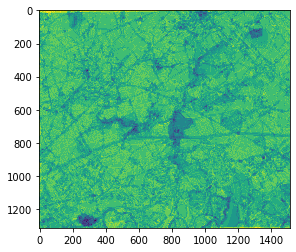

In [272]:
plt.imshow(surface)
plt.show()

In [282]:
tic = time.time()
out, members = watershed_transform(surface, 250000, compact=0.01)
print("Time for scale", scale,":", round(time.time() - tic,3), "(shape:", red5.shape, ")")

number seeds then 220746
Time for scale 2 : 1138.358 (shape: (755, 656) )


### Results:

Seeds: 5000

* Time for scale 5 : 1.185 (shape: (302, 262) )
* Time for scale 4 : 1.165  )
* Time for scale 2 : 6.658 (shape: (755, 656) )
* Time for full : 30.538 (shape: (1313, 1511) )

Seeds: 10000

Time for scale 2 : 14.146 (shape: (755, 656) )

Seeds: 20000

Time for scale 2 : 25.454 (shape: (755, 656) )  (ACTUALLY: would be 500 000 vertices)

Seeds: 31000

Time for scale 2 : 41.408 (shape: (755, 656) )

Seeds: 40607

Time for scale 1 : 207.016 (shape: (755, 656) ) --> already 3 min (ACTUALLY 1.9 vertices) 

Seeds 220 000 --> 1/8 th of all vertices are kept:

Time for scale 1: 1138 sec = 19 min

--> Seems to scale linear with number of seeds

In [275]:
surface.shape

(1313, 1511)

In [281]:
1313 * 1511

1983943

In [287]:
print(np.sum(test>0)/len(test.flatten()))

0.4408270277445905


In [288]:
302*262

79124

In [299]:
n_seeds = 3000
grid = util.regular_grid(test.shape, n_points=n_seeds)

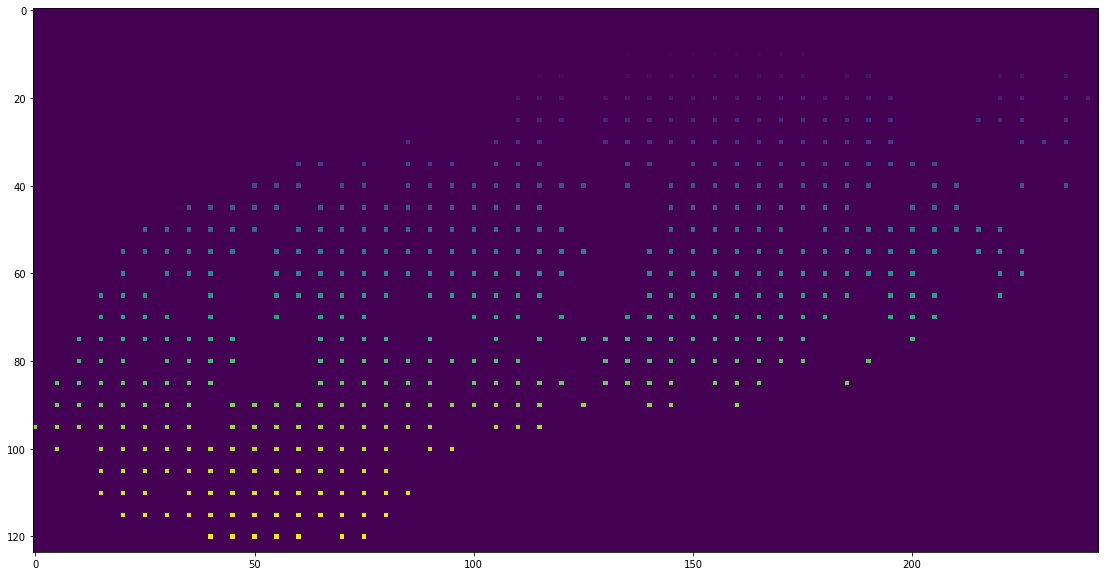

In [307]:
seeds = np.zeros(test.shape, dtype=int)
seeds[grid] = np.arange(seeds[grid].size
                                ).reshape(seeds[grid].shape) + 1
plt.figure(figsize=(20,10))
plt.imshow(new)
plt.show()

In [306]:
cluster_scale = 5
lab = 0
x_len, y_len = test.shape
new = np.zeros(test.shape)
for i in np.arange(0,x_len, cluster_scale):
    for j in np.arange(0,y_len, cluster_scale):
        if test[i,j]:
            new[i,j] = lab
            lab += 1